In [1]:
from gptopt.optim.attn_kq import *
from utils_pdhg import *

/mnt/home/tparshakova/Documents/GPT-opt/venv/lib64/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import torch

from gptopt.utils import set_seed
set_seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
import sys
from pathlib import Path

# Walk up until we find the repo root marker
repo_root = Path.cwd().resolve()
while repo_root != repo_root.parent and not (repo_root / "run_hydra.py").exists():
    repo_root = repo_root.parent

sys.path.insert(0, str(repo_root))

from sweeps.sweep_utils import plot_lr_sweep_over_models

# Comparison of methods to solve
$$
\begin{array}{ll}
{\text{minimize}} &  
\langle G_1, Z_1 \rangle + \langle G_2, Z_2 \rangle + \frac{\mu}{2}(\|Z_1\|_F^2 + \|Z_2\|_F^2)  + h(X) \\ 
\text{subject to} & X = Z_1^\top B + A^\top Z_2,
\end{array} 
$$

## PDHG
$$
\begin{aligned}
Y^{t+1} &= \operatorname{prox}_{\rho h^*}(Y^t + \rho 
((2Z_1^t - Z_1^{t-1})^\top B  + A^\top (2Z_2^t - Z_2^{t-1})))\\
\begin{bmatrix}
    Z_1^{t+1} \\ Z_2^{t+1}
\end{bmatrix} &=  \frac{1}{1 + \mu\gamma}\left (\begin{bmatrix}
    Z_1^t \\ Z_2^t
\end{bmatrix} - \gamma \left (
\begin{bmatrix}
    B(Y^{t+1})^\top \\ AY^{t+1}
\end{bmatrix}
+ \begin{bmatrix}
    G_1 \\ G_2
\end{bmatrix} \right ) \right )
\end{aligned}
$$




## FISTA for dual solve

$$
\begin{array}{ll}
{\text{maximize}} &  
-\frac{1}{2\mu}\|\mathcal{A}^*(Y) + G\|_F^2 - h^*(Y)
\end{array}  
$$
recover primal using
$$
Z = -\frac{1}{\mu}(\mathcal{A}^*(Y) + G)
$$

$$
\begin{aligned}
Y^{t+1} &= \mathbf{prox}_{\frac{1}{\alpha} h^*}\left (\tilde Y^t - \frac{1}{\alpha} \mathcal{A}(\mathcal{A}^*(\tilde Y^t) + G)\right )\\
\tilde Y^{t+1} &= Y^{t+1} + \frac{k-1}{k+2} ( Y^{t+1} -  Y^t)
\end{aligned}
$$

In [4]:
n_layer = 4
std1 = 1 #0.02 / np.sqrt(2.0 * n_layer)
std2 = 1 #0.01
rank_ratio = 0.7
max_iter = 20



mu_range_fista = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 1e-4, 5e-5, 1e-5]
mu_range_pdhg = [100, 10, 1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 1e-4, 5e-5, 1e-5, 0]
beta = 1.

In [5]:
# Torch prox for h* (uses prox_l1 from pdhg.py)
prox_h_conj = lambda y, rho, R: prox_l1(y, rho * beta, R=R)
h_conj = lambda y: beta * torch.abs(y).sum()

#  $m=n=1000$

In [6]:
m = n = 1000
std2 = 0.1
A, B, G1, G2, A_np, B_np, G1_np, G2_np, lamb_max = gaussian_data(m, n, std1=std1, std2=std2, 
                                        rank_ratio=rank_ratio, G_in_range=True)

mu_max = (G1.t() @ B + A.t() @ G2).abs().max().item() / beta
nA = A.pow(2).sum().sqrt().item()
nB = B.pow(2).sum().sqrt().item()
lamb_max = (nA * nA + nB * nB) ** 0.5 
print(f"{lamb_max=:.4e}, {mu_max=:.4e}")

lamb_max=1.4153e+03, mu_max=1.4487e+00


In [7]:
max_iter = 20

In [8]:
df_residuals = compare_methods_fista_pdhg_mu(A, B, G1, G2, beta, mu_range_fista=mu_range_fista,
                                mu_range_pdhg=mu_range_pdhg,
                                stopping=False, max_iter=max_iter)

Method                 Obj          Viol           Mu
-----------------------------------------------------
fista                 -2.171516e+01  5.960464e-07  1.0000e+00
pdhg                  -2.171516e+01  4.768372e-07  1.0000e+00
rehpdhg               -2.171516e+01  4.768372e-07  1.0000e+00
fista                 -4.335614e+01  9.315498e-01  5.0000e-01
pdhg                  -4.342912e+01  9.988852e-01  5.0000e-01
rehpdhg               -4.342871e+01  9.985125e-01  5.0000e-01
fista                 -2.046521e+02  8.019479e+00  1.0000e-01
pdhg                  -2.169446e+02  8.983665e+00  1.0000e-01
rehpdhg               -2.168756e+02  8.978221e+00  1.0000e-01
fista                 -4.024145e+02  1.677326e+01  5.0000e-02
pdhg                  -4.337748e+02  1.896280e+01  5.0000e-02
rehpdhg               -4.335987e+02  1.895043e+01  5.0000e-02
fista                 -1.982978e+03  8.675268e+01  1.0000e-02
pdhg                  -2.168391e+03  9.879495e+01  1.0000e-02
rehpdhg               -2

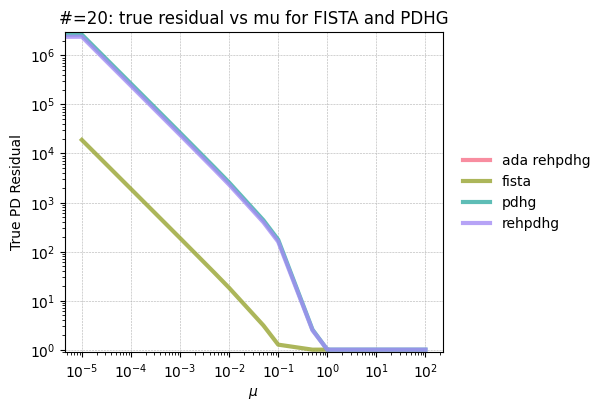

In [9]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_true_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: true residual vs mu for FISTA and PDHG")

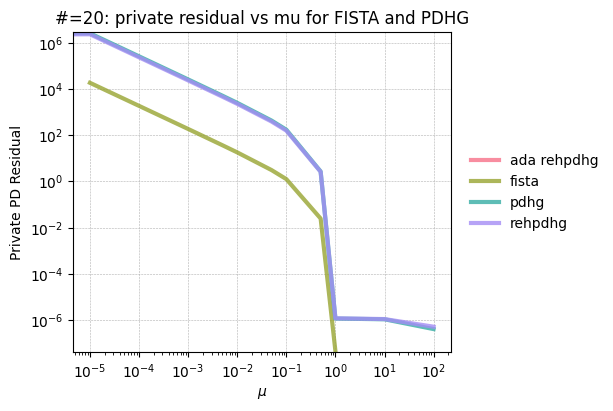

In [10]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: private residual vs mu for FISTA and PDHG")

In [11]:
max_iter = 200

In [12]:
df_residuals = compare_methods_fista_pdhg_mu(A, B, G1, G2, beta, mu_range_fista=mu_range_fista,
                                mu_range_pdhg=mu_range_pdhg,
                                stopping=False, max_iter=max_iter)

Method                 Obj          Viol           Mu
-----------------------------------------------------
fista                 -2.171516e+01  5.960464e-07  1.0000e+00
pdhg                  -2.171516e+01  4.768372e-07  1.0000e+00
rehpdhg               -2.171516e+01  4.768372e-07  1.0000e+00
fista                 -4.229652e+01  1.846802e-02  5.0000e-01
pdhg                  -4.139865e+01  0.000000e+00  5.0000e-01
rehpdhg               -4.233191e+01  4.784214e-02  5.0000e-01
fista                 -8.435608e+01  4.171546e-01  1.0000e-01
pdhg                  -6.931281e+00  1.740655e+00  1.0000e-01
rehpdhg               -2.168756e+02  8.978221e+00  1.0000e-01
fista                 -9.126155e+01  9.241093e-01  5.0000e-02
pdhg                  -4.337748e+02  1.896280e+01  5.0000e-02
rehpdhg               -4.335987e+02  1.895043e+01  5.0000e-02
fista                 -9.777388e+01  4.880024e+00  1.0000e-02
pdhg                  -2.168391e+03  9.879495e+01  1.0000e-02
rehpdhg               -2

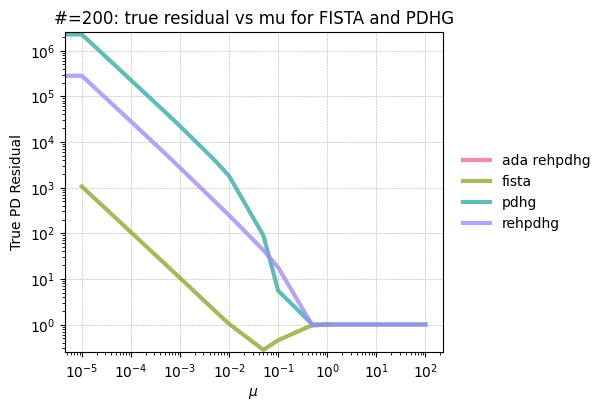

In [13]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_true_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: true residual vs mu for FISTA and PDHG")

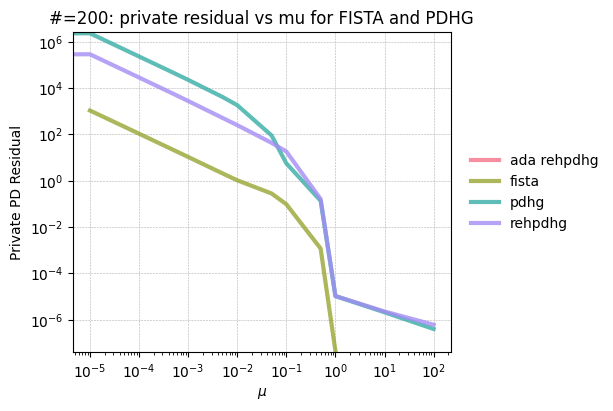

In [14]:
_ = plot_lr_sweep_over_models(df_residuals, ycol="r_res", xcol="mu", ylog=True,
                              title=f"#={max_iter}: private residual vs mu for FISTA and PDHG")